### Fixed hyperparameter

In [1]:
import joblib
import scipy
from assocplots.qqplot import *
# from qmplot import qqplot
import matplotlib.pyplot as plt
from scipy.stats import beta

In [2]:
def read_pval(path):
    pvals = []
    pvals_perm = []
    with open(path, 'rb') as f:
        data = joblib.load(f)
        for j, d in enumerate(data):
            if d[0] == None:
                continue
            pvals.append(d[0])
            pvals_perm.append(d[1])

    return pvals,pvals_perm

In [3]:
path='./sim_M_50_known_kernel_100.pkl'
pvals,_ = read_pval(path)


/home/boyang1995/anaconda3/lib/python3.8/site-packages/assocplots/qqplot.py:69: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log10(q_th[:n_quantiles]), -np.log10(q_data[:n_quantiles]), '.', color=color[j], label=labels[j])
/home/boyang1995/anaconda3/lib/python3.8/site-packages/assocplots/qqplot.py:78: RuntimeWarning: divide by zero encountered in log10
  plt.fill_between(-np.log10(q_th), -np.log10(q_err[:,0]), -np.log10(q_err[:,1]), color=color[j], alpha=fill_dens[j], label='%1.3f CI'%alpha)


Text(0.5, 33.0, 'Expected $-log_{10}{(P)}$')

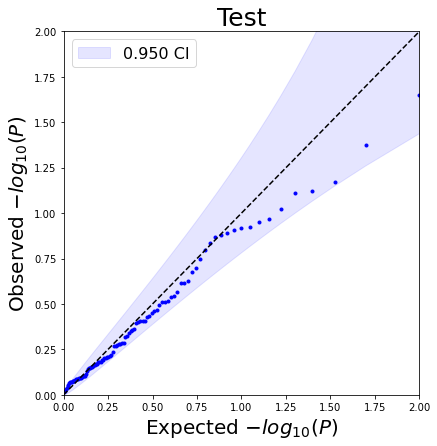

In [4]:
f, ax = plt.subplots(figsize=(6, 6), facecolor="w", edgecolor="k")
qqplot(
#     data=pvals,
        [pvals],
           [''],
           color=['b'], 
#            marker="o",
           title="Test",
#            xlabel=r"Expected $-log_{10}{(P)}$",
#            ylabel=r"Observed $-log_{10}{(P)}$",
#            dpi=300,
           distribution='beta',
#            figname="output_QQ_plot.png",
#            ax=ax
      )
plt.legend(prop={'size': 16},markerscale=2.)
plt.title(f'Test',size=25)
plt.ylabel(r"Observed $-log_{10}{(P)}$", size = 20, )
plt.xlabel(r"Expected $-log_{10}{(P)}$", size = 20, )

### Unknown hyperparameter

* When testing under multiple kernel hyperparameters, we select the minimum p-value among them. Then we use the permutation test to generate the null distribution. 

* We aggregate the permtutation statistics across all the testing sets to form the null distribution. This works well under the genome-wide sets testing. One underlying assumptions of it relies on the sets have similar structure so that the null statistics are exchangeable. To mimic it, we use a sliding window to create the annotation file.

* The unknown distribution is learned via KDE

* If you testing region are limted, and the sets are from independent, it is suggested generate each set's own null distribution with more number of permutation

In [5]:
def p_val_kde(kde, X, grid=1000):
    min_int = np.min(X)
    max_int = np.max(X)
    cum = kde.integrate_box_1d(0, 20)
    p = np.asarray([kde.integrate_box_1d(x, 20)/cum for x in X])
    return p
def KDE(trait, info, savePath=None,save=False):
    p_values,p_values_null=info
    
    p_values = p_values[(p_values>-1)&(p_values<=1)]
    print(f'valid p value length is {len(p_values)}')
    
    
#     print(f'Negative p-value is {p_values[p_values<=0]}\n the corresponding Indices are {Index[p_values<=0]}\n and the corresponding Chrs are {Chr[p_values<=0]}')
    p_values[p_values<=0] = 1e-15
    p_values_null = p_values_null[p_values_null<=1]
    stat_null = -np.log10(p_values_null)
    stat = -np.log10(p_values)
    print(len(p_values))
    
    
    plt.figure(figsize=(6,4))
    (n, bins, patches) = plt.hist(stat_null,bins=100)
    plt.title('null distribution')

    plt.figure(figsize=(6,4))
    (n, bins, patches) = plt.hist(stat,bins=100)
    plt.title('True distribution')
    avebin = (bins[0:-1:1] + bins[1::1])/2
    data = np.concatenate((avebin.reshape(-1,1),n.reshape(-1,1)),axis=1)

    density = scipy.stats.gaussian_kde(stat_null)
    plt.figure(figsize=(6,4))
    y = density(avebin)
    plt.plot(avebin,y)
    
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    csfont = {'fontname':'Times New Roman'}

            
    orig_p = p_val_kde(density,stat)

    return orig_p,density


valid p value length is 999
999


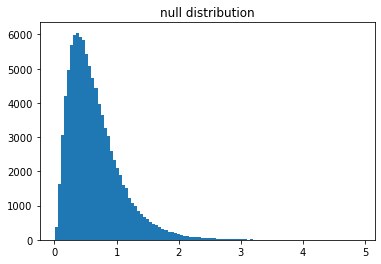

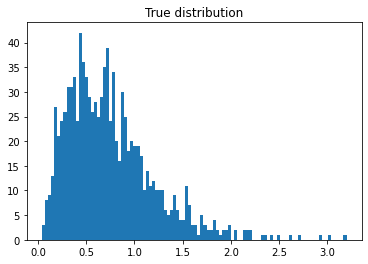

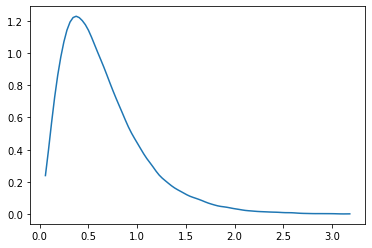

<Figure size 640x480 with 0 Axes>

In [6]:
path='./sim_M_50_unknown_kernel_overlap_more_999.pkl'
# path='/home/boyang1995/research/FastKAST_revise/FastKAST/small_results/small_M_50_unknown_kernel_overlap_more_2715.pkl'
min_pvals,pvals_perm = read_pval(path)
pvals_perm = np.array(pvals_perm).flatten()
min_pvals = np.array(min_pvals)

est_pval,density = KDE('Test (unknown)', (min_pvals,pvals_perm),save=False)

/home/boyang1995/anaconda3/lib/python3.8/site-packages/assocplots/qqplot.py:69: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log10(q_th[:n_quantiles]), -np.log10(q_data[:n_quantiles]), '.', color=color[j], label=labels[j])
/home/boyang1995/anaconda3/lib/python3.8/site-packages/assocplots/qqplot.py:78: RuntimeWarning: divide by zero encountered in log10
  plt.fill_between(-np.log10(q_th), -np.log10(q_err[:,0]), -np.log10(q_err[:,1]), color=color[j], alpha=fill_dens[j], label='%1.3f CI'%alpha)


Text(0.5, 33.0, 'Expected $-log_{10}{(P)}$')

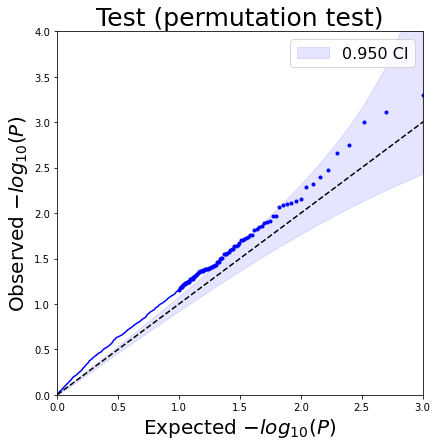

In [7]:
f, ax = plt.subplots(figsize=(6, 6), facecolor="w", edgecolor="k")
qqplot(
#     data=pvals,
        [est_pval],
           [''],
           color=['b'], 
#            marker="o",
           title="Test",
#            xlabel=r"Expected $-log_{10}{(P)}$",
#            ylabel=r"Observed $-log_{10}{(P)}$",
#            dpi=300,
           distribution='beta',
#            figname="output_QQ_plot.png",
#            ax=ax
      )
plt.legend(prop={'size': 16},markerscale=2.)
plt.title(f'Test (permutation test)',size=25)
plt.ylabel(r"Observed $-log_{10}{(P)}$", size = 20, )
plt.xlabel(r"Expected $-log_{10}{(P)}$", size = 20, )